#Setup Code

Install tensorboard logger for logging and mount my drive.

In [1]:
!pip install tensorboard_logger
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Manage imports here.

In [0]:
import math
import time
import os
import shutil
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import torch.backends.cudnn as cudnn
import torch.distributions as dist
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tensorboard_logger import configure, log_value

# import torch.nn.parallel
# import torch.distributed as dist
# import torch.utils.data.distributed

#Loss Functions

Implement custom loss functions here.

In [0]:
# class AleatoricLoss(nn.Module):
#     def __init__(self, T_samples=1):
#         super(AleatoricLoss, self).__init__()
#         self.T_samples = T_samples

#     def forward(self, input, target, model):
#         probs = []

#         # For t from 1 ~ T, do:
#         for i in range(self.T_samples):
#             # Get f^(W_hat_t)(x) from putting input to the model with dropout
#             output = model.forward(input)

#             # Compute softmax on the output per image
#             output = F.softmax(output, dim=1)

#             # Add the batch to the probabilities array
#             probs.append(output)

#         # Compute the mean of probabilities
#         probs = torch.stack(probs, dim=0)
#         mean = probs.mean(dim=0)

#         # Sample prediction from probability distribution
#         prob_dist = dist.categorical.Categorical(mean)
#         sampled = prob_dist.sample()

#         # Compare prediction to target and compute mean squared error
#         ones = torch.ones_like(sampled, dtype=torch.float).cuda()
#         correct = (sampled == target).type(torch.FloatTensor).cuda()
#         return F.mse_loss(correct, ones)

class EpistemicLoss(nn.Module):
    def __init__(self, T_samples=1):
        super(EpistemicLoss, self).__init__()
        self.T_samples = T_samples

    def forward(self, input, target, model):
        probs = []

        # For t from 1 ~ T, do:
        for i in range(self.T_samples):
            # Get f^(W_hat_t)(x) from putting input to the model with dropout
            output = model.forward(input)

            # Compute softmax on the output per image
            output = F.softmax(output, dim=1)

            # Add the batch to the probabilities array
            probs.append(output)

        # Compute the mean of probabilities
        probs = torch.stack(probs, dim=0)
        mean = probs.mean(dim=0)

        # Sample prediction from probability distribution
        prob_dist = dist.categorical.Categorical(mean)
        sampled = prob_dist.sample()

        # Compare prediction to target and compute mean squared error
        ones = torch.ones_like(sampled, dtype=torch.float).cuda()
        correct = (sampled == target).type(torch.FloatTensor).cuda()
        return F.mse_loss(correct, ones)

#Model

We will use PyramidNet (https://github.com/dyhan0920/PyramidNet-PyTorch) for our model. The code was copied and modified instead of cloned due to necessary modification to the loss function.

In [0]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    outchannel_ratio = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, planes, stride)        
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(out)        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
       
        if self.downsample is not None:
            shortcut = self.downsample(x)
            featuremap_size = shortcut.size()[2:4]
        else:
            shortcut = x
            featuremap_size = out.size()[2:4]

        batch_size = out.size()[0]
        residual_channel = out.size()[1]
        shortcut_channel = shortcut.size()[1]

        if residual_channel != shortcut_channel:
            padding = torch.autograd.Variable(torch.cuda.FloatTensor(batch_size, residual_channel - shortcut_channel, 
                                                                     featuremap_size[0], featuremap_size[1]).fill_(0)) 
            out += torch.cat((shortcut, padding), 1)
        else:
            out += shortcut 

        return out


class Bottleneck(nn.Module):
    outchannel_ratio = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, (planes*1), kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d((planes*1))
        self.conv3 = nn.Conv2d((planes*1), planes * Bottleneck.outchannel_ratio, kernel_size=1, bias=False)
        self.bn4 = nn.BatchNorm2d(planes * Bottleneck.outchannel_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn4(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)
            featuremap_size = shortcut.size()[2:4]
        else:
            shortcut = x
            featuremap_size = out.size()[2:4]

        batch_size = out.size()[0]
        residual_channel = out.size()[1]
        shortcut_channel = shortcut.size()[1]

        if residual_channel != shortcut_channel:
            padding = torch.autograd.Variable(torch.cuda.FloatTensor(batch_size, residual_channel - shortcut_channel, 
                                                                     featuremap_size[0], featuremap_size[1]).fill_(0)) 
            out += torch.cat((shortcut, padding), 1)
        else:
            out += shortcut 

        return out


class PyramidNet(nn.Module):
    def __init__(self, dataset, depth, alpha, num_classes, bottleneck=False, dropout_rate=0.5):
        super(PyramidNet, self).__init__()   	
        self.dataset = dataset
        self.inplanes = 16
        if bottleneck == True:
            n = int((depth - 2) / 9)
            block = Bottleneck
        else:
            n = int((depth - 2) / 6)
            block = BasicBlock

        self.addrate = alpha / (3*n*1.0)
        self.dropout_rate = dropout_rate

        self.input_featuremap_dim = self.inplanes
        self.conv1 = nn.Conv2d(3, self.input_featuremap_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.input_featuremap_dim)

        self.featuremap_dim = self.input_featuremap_dim 
        self.layer1 = self.pyramidal_make_layer(block, n)
        self.layer2 = self.pyramidal_make_layer(block, n, stride=2)
        self.layer3 = self.pyramidal_make_layer(block, n, stride=2)

        self.final_featuremap_dim = self.input_featuremap_dim
        self.bn_final= nn.BatchNorm2d(self.final_featuremap_dim)
        self.relu_final = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(self.final_featuremap_dim, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def pyramidal_make_layer(self, block, block_depth, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.AvgPool2d((2,2), stride = (2, 2), ceil_mode=True)

        layers = []
        self.featuremap_dim = self.featuremap_dim + self.addrate
        layers.append(block(self.input_featuremap_dim, int(round(self.featuremap_dim)), stride, downsample))
        for i in range(1, block_depth):
            temp_featuremap_dim = self.featuremap_dim + self.addrate
            layers.append(block(int(round(self.featuremap_dim)) * block.outchannel_ratio, int(round(temp_featuremap_dim)), 1))
            self.featuremap_dim  = temp_featuremap_dim
        self.input_featuremap_dim = int(round(self.featuremap_dim)) * block.outchannel_ratio

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.bn_final(x)
        x = self.relu_final(x)
        x = F.dropout(x, p=self.dropout_rate)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
    
        return x

Initialize config variables needed for the model. We will use a recommended config, which is "PyramidNet-110 (alpha=48 without bottleneck) on CIFAR-10 dataset with a single-GPU".

In [0]:
best_err1 = 100
best_err5 = 100

augment = True # Whether to use standard augmentation for CIFAR dataset
dataset_name = "cifar10" # Specify whether to use CIFAR-10 or CIFAR-100
loss_func = "epistemic" # Specify which loss function to use
# loss_func = "cross_entropy" # Uncomment this and comment upper line if using cross entropy loss
batch_size = 32 # Mini-batch size
workers = 4 # Number of data loading workers
depth = 110 # Depth of the network
alpha = 64 # Number of new channel increases per depth
bottleneck = False # Whether to use bottleneck or basicblock
learning_rate = 0.1 # Initial learning rate
momentum = 0.9 # Momentum value for SGD
weight_decay = 1e-4 # Weight decay for SGD
resume = None # Path to resume from if restarting
start_epoch = 1 # Manual epoch number in case of restarts
epochs = 5 # Total epochs to run
print_freq = 25 # Print frequency
verbose = True # Whether to print per frequency
T_samples = 10 # T sampled masked model weights to use
dropout_rate = 0.25 # Dropout rate for epistemic loss

Define functions to train and validate the model, copied and modified from the repository.

In [0]:
def save_to_pickle(dataset, fileloc):
    filename = fileloc + ".pickle"
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)
    print("Saved to {}".format(filename))

def load_from_pickle(fileloc):
    filename = fileloc + ".pickle"
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    print("Loaded from {}".format(filename))
    return dataset

def train(train_loader, model, criterion, optimizer, epoch, loss_func):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    current_LR = get_learning_rate(optimizer)[0]
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(async=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        if loss_func == "epistemic":
            loss = criterion(input_var, target_var, model)
        else:
            loss = criterion(output, target_var)

        # measure accuracy and record loss
        err1, err5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data.item(), input.size(0))
        top1.update(err1[0], input.size(0))
        top5.update(err5[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss = torch.autograd.Variable(loss, requires_grad = True)
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0 and verbose == True:
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'LR: {LR:.6f}\t' 
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top 1-err {top1.val:.4f} ({top1.avg:.4f})\t'
                  'Top 5-err {top5.val:.4f} ({top5.avg:.4f})'.format(
                   epoch, epochs, i, len(train_loader), LR=current_LR, batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1, top5=top5))
    log_value('train_loss', losses.avg, epoch)
    log_value('train_error', top1.avg, epoch)

def validate(val_loader, model, criterion, epoch, loss_func):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()

    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)

        # for PyTorch 0.4.x, volatile=True is replaced by with torch.no.grad(), so uncomment the followings:
        with torch.no_grad():
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)
            output = model(input_var)
            if loss_func == "epistemic":
                loss = criterion(input_var, target_var, model)
            else:
                loss = criterion(output, target_var)

        # measure accuracy and record loss
        err1, err5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data.item(), input.size(0))
        top1.update(err1[0], input.size(0))
        top5.update(err5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0 and verbose == True:
            print('Test (on val set): [{0}/{1}][{2}/{3}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top 1-err {top1.val:.4f} ({top1.avg:.4f})\t'
                  'Top 5-err {top5.val:.4f} ({top5.avg:.4f})'.format(
                  epoch, epochs, i, len(val_loader), batch_time=batch_time, loss=losses,
                  top1=top1, top5=top5))

    print('* Epoch: [{0}/{1}]\t Top 1-err {top1.avg:.3f}  Top 5-err {top5.avg:.3f}\t Test Loss {loss.avg:.3f}'.format(epoch, epochs, top1=top1, top5=top5, loss=losses))
    log_value('val_loss', losses.avg, epoch)
    log_value('val_acc', top1.avg, epoch)
    return top1.avg, top5.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    directory = "/../../../content/gdrive/My Drive/PyramidNet/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, directory + 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.1 ** (epoch // (epochs*0.5))) * (0.1 ** (epoch // (epochs*0.75)))
    
    log_value('learning_rate', lr, epoch)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
       lr +=[ param_group['lr'] ]
    return lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res

Initialize the model, copied and modified from the repository.

In [7]:
configure("/../../../content/gdrive/My Drive/PyramidNet")
# torch.cuda.empty_cache()
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                  std=[x/255.0 for x in [63.0, 62.1, 66.7]])    
if augment:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
        ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

if dataset_name == 'cifar100':
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100('../data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100('../data', train=False, transform=transform_test),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True) 
    numberofclass = 100         
elif dataset_name == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=False, transform=transform_test),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    numberofclass = 10
else: 
    raise Exception ('Wrong dataset input: {}'.format(dataset_name)) 

print("=> creating model '{}'".format("PyramidNet"))
model = PyramidNet(dataset_name, depth, alpha, numberofclass, bottleneck=bottleneck, dropout_rate=dropout_rate)
model = torch.nn.DataParallel(model).cuda()

print(model)
print('the number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

# define loss function (criterion) and optimizer
if loss_func == "epistemic":
    criterion = EpistemicLoss(T_samples=T_samples).cuda()
else:
    criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=momentum, 
                            weight_decay=weight_decay, nesterov=True)

# optionally resume from a checkpoint
# if resume:
#     if os.path.isfile(resume):
#         print("=> loading checkpoint '{}'".format(resume))
#         checkpoint = torch.load(resume)
#         start_epoch = checkpoint['epoch']
#         best_err1 = checkpoint['best_err1']
#         best_err5 = checkpoint['best_err5']            
#         model.load_state_dict(checkpoint['state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer'])
#         print("=> loaded checkpoint '{}' (epoch {})"
#               .format(resume, checkpoint['epoch']))
#     else:
#         print("=> no checkpoint found at '{}'".format(resume))

cudnn.benchmark = True

Extracting ../data/cifar-10-python.tar.gz to ../data
=> creating model 'PyramidNet'
DataParallel(
  (module): PyramidNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(16, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(17, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (con

Train and validate the model using custom classification loss function, copied and modified from the repository.

In [8]:
results = defaultdict(list)

for epoch in range(start_epoch, epochs + 1):
    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch, loss_func)

    # evaluate on validation set
    err1, err5 = validate(val_loader, model, criterion, epoch, loss_func)

    # remember best prec@1 and save checkpoint
    is_best = err1 <= best_err1
    best_err1 = min(err1, best_err1)
    if is_best:
        best_err5 = err5
    print ('Current best accuracy (top-1 and 5 error):', best_err1, best_err5)
    save_checkpoint({
        'epoch': epoch,
        'arch': "PyramidNet",
        'state_dict': model.state_dict(),
        'best_err1': best_err1,
        'best_err5': best_err5,
        'optimizer' : optimizer.state_dict(),
    }, is_best)

    results["model"].append(model)
    results["epoch"].append(epoch)
    results["err1"].append(err1)
    results["err5"].append(err5)
    results["best_err1"].append(best_err1)
    results["best_err5"].append(best_err5)

    save_to_pickle(results, "/../../../content/gdrive/My Drive/PyramidNet/{}-checkpoint-epoch-{}".format(loss_func, epoch))

print ('Best accuracy (top-1 and 5 error):', best_err1, best_err5)  

save_to_pickle(results, "/../../../content/gdrive/My Drive/PyramidNet/{}-results".format(loss_func))

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format)


Epoch: [1/5][0/1563]	LR: 0.100000	Time 1.306 (1.306)	Data 0.334 (0.334)	Loss 0.8750 (0.8750)	Top 1-err 96.8750 (96.8750)	Top 5-err 43.7500 (43.7500)
Epoch: [1/5][25/1563]	LR: 0.100000	Time 0.358 (0.383)	Data 0.000 (0.013)	Loss 0.9688 (0.9243)	Top 1-err 90.6250 (89.0625)	Top 5-err 59.3750 (46.3942)
Epoch: [1/5][50/1563]	LR: 0.100000	Time 0.338 (0.364)	Data 0.000 (0.007)	Loss 0.9375 (0.9130)	Top 1-err 93.7500 (89.5221)	Top 5-err 40.6250 (47.0588)
Epoch: [1/5][75/1563]	LR: 0.100000	Time 0.342 (0.358)	Data 0.000 (0.005)	Loss 0.9062 (0.9087)	Top 1-err 96.8750 (89.7615)	Top 5-err 53.1250 (47.1628)
Epoch: [1/5][100/1563]	LR: 0.100000	Time 0.342 (0.355)	Data 0.000 (0.003)	Loss 0.8125 (0.9109)	Top 1-err 87.5000 (90.3465)	Top 5-err 46.8750 (48.3292)
Epoch: [1/5][125/1563]	LR: 0.100000	Time 0.354 (0.354)	Data 0.000 (0.003)	Loss 0.9062 (0.9080)	Top 1-err 81.2500 (90.3274)	Top 5-err 43.7500 (48.5615)
Epoch: [1/5][150/1563]	LR: 0.100000	Time 0.341 (0.353)	Data 0.000 (0.002)	Loss 0.9375 (0.9075)	Top 

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Epoch: [2/5][0/1563]	LR: 0.100000	Time 0.628 (0.628)	Data 0.163 (0.163)	Loss 0.7188 (0.7188)	Top 1-err 84.3750 (84.3750)	Top 5-err 50.0000 (50.0000)
Epoch: [2/5][25/1563]	LR: 0.100000	Time 0.378 (0.373)	Data 0.000 (0.006)	Loss 0.9062 (0.8930)	Top 1-err 93.7500 (89.1827)	Top 5-err 50.0000 (49.7596)
Epoch: [2/5][50/1563]	LR: 0.100000	Time 0.362 (0.366)	Data 0.000 (0.003)	Loss 0.9375 (0.8971)	Top 1-err 90.6250 (89.6446)	Top 5-err 46.8750 (49.3873)
Epoch: [2/5][75/1563]	LR: 0.100000	Time 0.349 (0.363)	Data 0.000 (0.002)	Loss 0.9062 (0.9009)	Top 1-err 100.0000 (89.7615)	Top 5-err 56.2500 (49.0954)
Epoch: [2/5][100/1563]	LR: 0.100000	Time 0.352 (0.362)	Data 0.000 (0.002)	Loss 0.8438 (0.9001)	Top 1-err 90.6250 (90.0062)	Top 5-err 46.8750 (48.7005)
Epoch: [2/5][125/1563]	LR: 0.100000	Time 0.347 (0.361)	Data 0.000 (0.001)	Loss 0.9062 (0.9000)	Top 1-err 78.1250 (89.8065)	Top 5-err 28.1250 (48.7351)
Epoch: [2/5][150/1563]	LR: 0.100000	Time 0.354 (0.361)	Data 0.000 (0.001)	Loss 0.8750 (0.9002)	Top

#Results

Try plotting the Top 1-error and Top 5-error computed.

Loaded from /../../../content/gdrive/My Drive/PyramidNet/epistemic-results.pickle


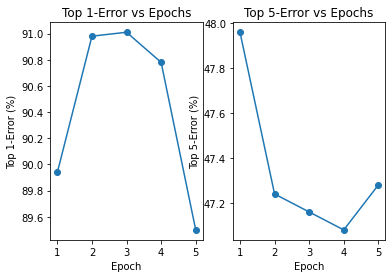

In [10]:
def plot_errors(results):
  plt.subplot(1, 2, 1)
  plt.plot(results["epoch"], results["err1"], "o-")
  plt.title("Top 1-Error vs Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Top 1-Error (%)")

  plt.subplot(1, 2, 2)
  plt.plot(results["epoch"], results["err5"], "o-")
  plt.title("Top 5-Error vs Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Top 5-Error (%)")
  
  # plt.gcf().set_size_inches(14, 4)
  plt.show()

results = load_from_pickle("/../../../content/gdrive/My Drive/PyramidNet/{}-results".format(loss_func))
plot_errors(results)

##Simple Analysis:

Since we are only observing the initial 5 epochs, which also lack learning rate decay (it decays every 30 epochs), we will not see much improvement on the accuracy. In fact, cross entropy loss function yields very similar results to the custom made epistemic loss function. 

However, this implementation provides a starting point to fine-tune and further train the model to yield better results with integration of epistemic uncertainty as classification loss function.